<h1><center>Проект Телеком</center></h1>

# Условие задачи <a class="anchor" id="1-bullet"></a>

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

- Целевой признак: столбец `'EndDate'` равен `'No'`.


- Основная метрика: AUC-ROC.


- Дополнительная метрика: Accuracy.


- Критерии оценки:

    - AUC-ROC < 0.75 — 0 sp
    - 0.75 ≤ AUC-ROC < 0.81 — 4 sp
    - 0.81 ≤ AUC-ROC < 0.85 — 4.5 sp
    - 0.85 ≤ AUC-ROC < 0.87 — 5 sp
    - 0.87 ≤ AUC-ROC < 0.88 — 5.5 sp
    - AUC-ROC ≥ 0.88 — 6 sp

# Содержание:

* [Условие задачи](#1-bullet)


* [Описание услуг](#2-bullet)


* [Описание данных](#3-bullet)


* [Импорт модулей](#4-bullet)


* [Константы](#4.1-bullet)


* [Функции](#4.2-bullet)


* [Загрузка данных](#5-bullet)


* [Исследовательский анализ данных](#6-bullet)


* [Подготовка признаков](#6.2-bullet)


* [Построение моделей](#7-bullet)


* [Тестирование моделей](#8-bullet)


* [Общий вывод](#9-bullet)


* [Отчет](#10-bullet)

# Описание услуг <a class="anchor" id="2-bullet"></a>

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.


2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);


- Выделенная линия технической поддержки (*TechSupport*);


- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);


- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных <a class="anchor" id="3-bullet"></a>

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

# Импорт модулей <a class="anchor" id="4-bullet"></a>

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy import stats
import warnings
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, StratifiedShuffleSplit, ParameterGrid
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import auc, roc_curve, accuracy_score, roc_auc_score
from sklearn.utils import shuffle

# Константы <a class="anchor" id="4.1-bullet"></a>

In [6]:
MAX_DATE = datetime.datetime(2020, 2, 1)
RANDOM_STATE = 12345

# Функции <a class="anchor" id="4.2-bullet"></a>

In [7]:
# Функция построения ROC-кривых для кросс-валидационных выборок

def cv_auc_roc_curve(X_train, y_train, cv, grid_cv):
    fig1 = plt.figure(figsize=[7,7])
    ax1 = fig1.add_subplot(111,aspect = 'equal')

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1
    for train,test in cv.split(X_train, y_train):
        prediction = grid_cv.fit(X_train.iloc[train],y_train.iloc[train]).predict_proba(X_train.iloc[test])
        fpr, tpr, t = roc_curve(y_train.iloc[test], prediction[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1   

    
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black',
            label='Random model')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC для выборок кросс-валидации модели '+str(type(grid_cv.best_estimator_).__name__))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc="lower right")
    plt.show()
    

# Загрузка данных <a class="anchor" id="5-bullet"></a>

* ####  Заргузим исходные датасеты

In [8]:
contract = pd.read_csv('datasets/final_provider/contract.csv')
personal = pd.read_csv('datasets/final_provider/personal.csv')
internet = pd.read_csv('datasets/final_provider/internet.csv')
phone = pd.read_csv('datasets/final_provider/phone.csv')

* #### Рассмотрим информацию о договоре

In [9]:
contract.info()
display(contract.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


* #### Рассмотрим персональные данные клиента

In [10]:
personal.info()
display(personal.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


* #### Рассмотрим информация об интернет-услугах

In [11]:
internet.info()
display(internet.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


* #### Рассмотрим персональные данные клиента

In [12]:
phone.info()
display(phone.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


* #### Выводы по этапу загрузки данных:

    1. Данные загружены
    2. Пропусков не наблюдается
    3. Все таблицы связаны ключевым заголовком customerID 

# Исследовательский анализ данных <a class="anchor" id="6-bullet"></a>

* #### Объединим все данные в сводную таблицу по заголовку customerID

* #### Ключевая информация для решения задачи находится в таблице контрактов (начало-конец договора), поэтому данные из других таблиц добавим в качестве вспомогательных  

In [13]:
data = contract.merge(personal, on='customerID', how='left').merge(internet, on='customerID', how='left').merge(phone, on='customerID', how='left')

data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


* #### Приведем столбцы начала и конца договора к типу дата 

In [14]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d', errors='coerce')

data[['BeginDate', 'EndDate']].info()
display(data[['BeginDate', 'EndDate']].head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   BeginDate  7043 non-null   datetime64[ns]
 1   EndDate    1869 non-null   datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 165.1 KB


,BeginDate,EndDate
0,2020-01-01,NaT
1,2017-04-01,NaT
2,2019-10-01,2019-12-01
3,2016-05-01,NaT
4,2019-09-01,2019-11-01


- #### На основе наличия даты окончания договора добавим признак активности клиента: Status - "0" - клиент не активный, "1" - клиент действующий

,BeginDate,EndDate,Status
0,2020-01-01,NaT,1
1,2017-04-01,NaT,1
2,2019-10-01,2019-12-01,0
3,2016-05-01,NaT,1
4,2019-09-01,2019-11-01,0


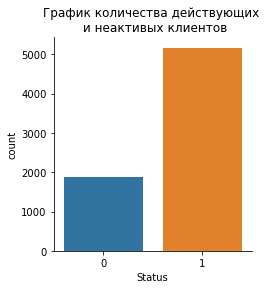

In [15]:
data.loc[data['EndDate'].isnull()==True, 'Status'] = 1
data.loc[data['EndDate'].isnull()==False, 'Status'] = 0
data['Status'] = data['Status'].astype('int64')

display(data[['BeginDate', 'EndDate', 'Status']].head())

sns.catplot(x='Status', data=data, kind='count', height=3.5)
plt.title('График количества действующих \n и неактивых клиентов')
plt.show()

- Из графика видно, что число действующих клиентов более чем в 2 раза превышает количество неактивных

* #### Оценим продолжительность договора для неактивных и действующих клиентов на момент 1 февраля 2020 года

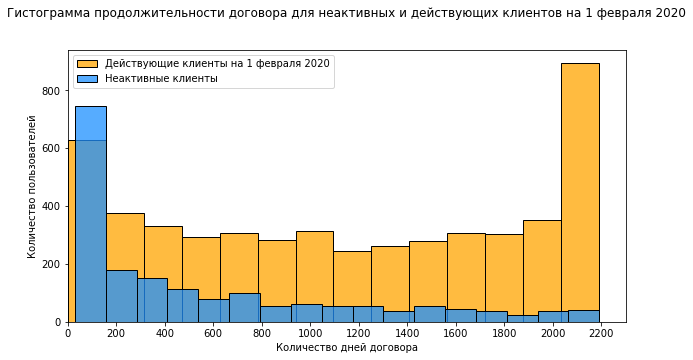

In [16]:
data.loc[data['Status'] == 0, 'ContractDuration'] = (data['EndDate']-data['BeginDate']).dt.days 
data.loc[data['Status'] == 1, 'ContractDuration'] = (MAX_DATE-data['BeginDate']).dt.days 


fig, ax = plt.subplots(figsize=(10,5))

sns.histplot(data.loc[data['Status'] == 1, 'ContractDuration'], 
             color='orange',
             label='Действующие клиенты на 1 февраля 2020',
             kde_kws={'alpha':.7},
             ax=ax)

sns.histplot(data.loc[data['Status'] == 0, 'ContractDuration'], 
             color='dodgerblue',
             label='Неактивные клиенты',
             kde_kws={'alpha':.7},
             ax=ax)

ax.set_xlim(0, 2300)
ax.set_xlabel('Количество дней договора')
ax.set_ylabel('Количество пользователей')
plt.xticks(np.arange(0, 2300, 200))

plt.title('Гистограмма продолжительности договора для неактивных и действующих клиентов на 1 февраля 2020', y=1.1)
plt.legend()
plt.show()


- На гистограмме распределения длительности договора для действующих клиентов выделяются два максимума - до 200 дней - новые клиенты и более 2000 дней - долговременные. Промежуточные варианты длительности договора представлены достаточно равномерно


- Из распределения длительности договора для неактивных клиентов можно сделать вывод, что большинство ушедших клиентов пользовались услугами менее 200 дней


- Пока можно сказать, что клиенты, отказавшиеся от предоставляемых услуг, в основном уходят в первые 200 дней пользования


- И наоборот, клиенты, пользующиеся услугами порядка 6 лет и больше, наименее вероятно уйдут

* #### Рассмотрим типы договоров среди неактивных и действующих клиентов

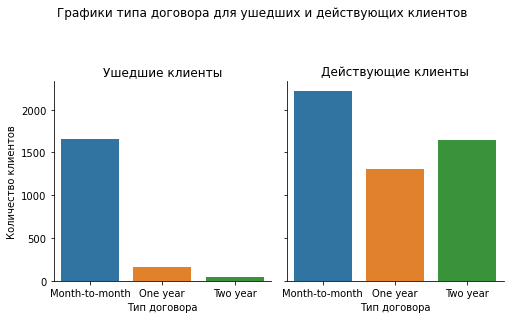

In [17]:
g = sns.catplot(x='Type', data=data, kind='count', col='Status', height=3.5)
axes = g.axes.flatten()
axes[0].set_title("Ушедшие клиенты")
axes[1].set_title("Действующие клиенты")
(g.set_axis_labels('Тип договора', 'Количество клиентов')
  .fig.suptitle('Графики типа договора для ушедших и действующих клиентов', y=1.2))

plt.show()

- Ожидаемо, клиенты, которые ушли, чаще всего заключали договор с ежемесячной оплатой. Это соотносится с преимущественной длительностью договора для неактивных пользователей - меньше года. Лишь малая часть ушедших клиентов заключала длительные договоры на 1-2 года


- Среди действующих клиентов также преобладают догоры с помесяцной оплатой, однако суммарная доля долгосрочных контрактов (1-2 года) выше доли краткосрочных 



- #### Оценим расходы неактивных и действующих клиентов

- Сперва изменим тип столбца TotalCharges, предварительно заменив пустые значения на произведение длительности контракта и ежемесяцной оплаты

In [18]:
data['TotalCharges'].loc[data['TotalCharges']==' '] = data['MonthlyCharges']*data['ContractDuration']/30
data['TotalCharges'] = data['TotalCharges'].astype('float64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


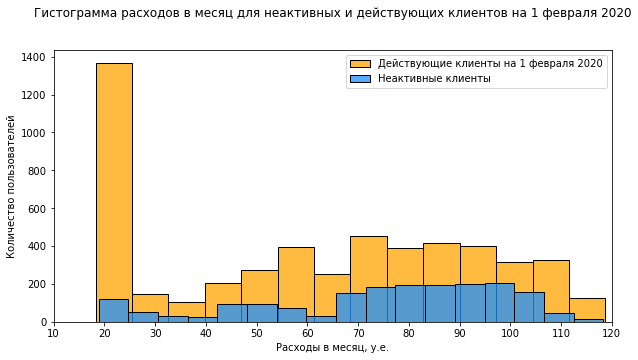

In [19]:
fig, ax = plt.subplots(figsize=(10,5))

sns.histplot(data.loc[data['Status'] == 1, 'MonthlyCharges'], 
             color='orange',
             label='Действующие клиенты на 1 февраля 2020',
             kde_kws={'alpha':.7},
             ax=ax)

sns.histplot(data.loc[data['Status'] == 0, 'MonthlyCharges'], 
             color='dodgerblue',
             label='Неактивные клиенты',
             kde_kws={'alpha':.7},
             ax=ax)

ax.set_xlim(10, 120)
ax.set_xlabel('Расходы в месяц, у.е.')
ax.set_ylabel('Количество пользователей')
plt.xticks(np.arange(10, 130, 10))

plt.title('Гистограмма расходов в месяц для неактивных и действующих клиентов на 1 февраля 2020', y=1.1)
plt.legend()
plt.show()

- Из гистограмм распределениям можно выделить явно выраженный максимум ежемесячной оплаты для действующих клиентов 20-25 у.е., для ушедших клиентов этот интервал  не является преобладающим

- Рассчитаем общие расходы из ежемесячной оплаты и длительности контракта и сравним с приведенными общими расходами, чтобы понять есть ли корреляция

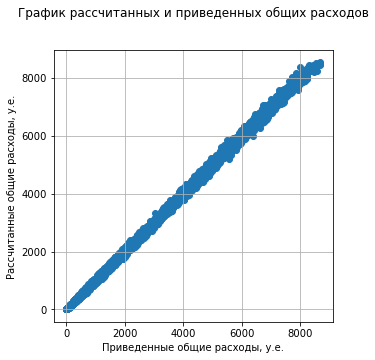

Корреляция между расcчитанными и приведенными расходами составляет 0.9996


In [20]:
total_charges = data['TotalCharges']
calculated_charges = data['MonthlyCharges']*data['ContractDuration']/30.5

fig, ax = plt.subplots( figsize=(5,5))
ax.scatter(x=total_charges, y=calculated_charges)
ax.set_xlabel('Приведенные общие расходы, у.е.')
ax.set_ylabel('Рассчитанные общие расходы, у.е.')
ax.grid()
plt.title('График рассчитанных и приведенных общих расходов', y=1.1)
plt.show()

charges_corr, _ = stats.pearsonr(calculated_charges, total_charges)
print('Корреляция между расcчитанными и приведенными расходами составляет', round(charges_corr, 4))

- Ожидаемо, корреляция между рассчитанными и приведенными общими расходами практически равна 1, поэтому приведенные общие расходы можно не рассматривать в качестве признака 

- Дополнительно оценим корреляцию между ежемесячным платежом и длительностью контракта

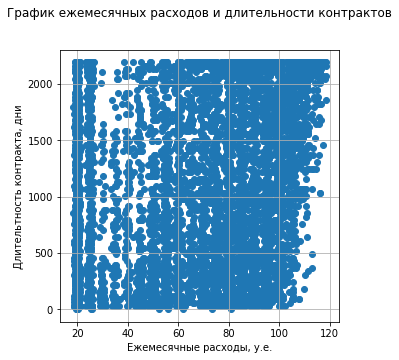

Корреляция между ежемесячными расходами и длительностью контракта составляет 0.25


In [21]:
monthly_charges = data['MonthlyCharges']
contract_duration = data['ContractDuration']

fig, ax = plt.subplots( figsize=(5,5))
ax.scatter(x=monthly_charges, y=contract_duration)
ax.set_xlabel('Ежемесячные расходы, у.е.')
ax.set_ylabel('Длительтность контракта, дни')
ax.grid()
plt.title('График ежемесячных расходов и длительности контрактов', y=1.1)
plt.show()

charges_corr, _ = stats.pearsonr(monthly_charges, contract_duration)
print('Корреляция между ежемесячными расходами и длительностью контракта составляет', round(charges_corr, 2))

- Корреляции между ежемесячными расходами и длительностью контракта не наблюдается

- #### Рассмотрим методы оплаты для действующих и неактивных клиентов

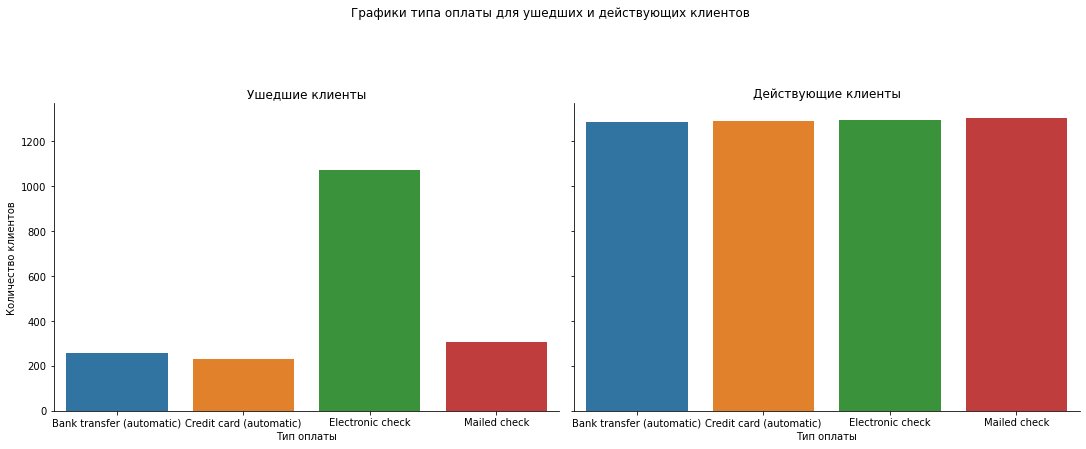

In [22]:
g = sns.catplot(x='PaymentMethod', data=data.sort_values(by='PaymentMethod'), kind='count', col='Status', height=5, aspect=1.5/1)
axes = g.axes.flatten()
axes[0].set_title("Ушедшие клиенты")
axes[1].set_title("Действующие клиенты")
(g.set_axis_labels('Тип оплаты', 'Количество клиентов')
  .fig.suptitle('Графики типа оплаты для ушедших и действующих клиентов', y=1.2))

plt.show()

- Можно отметить, что для ушедших клиентов более характерно использование электроннго чека, для действующих клиентов - все методы представлены равномерно

- #### Оценим наличие или отсутствие небумажного чека среди неактивных и действующих пользователей

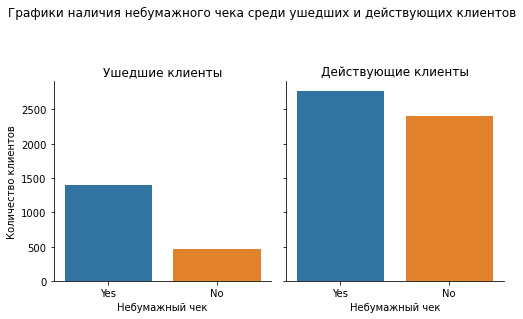

In [23]:
g = sns.catplot(x='PaperlessBilling', data=data, kind='count', col='Status', height=3.5)
axes = g.axes.flatten()
axes[0].set_title("Ушедшие клиенты")
axes[1].set_title("Действующие клиенты")
(g.set_axis_labels('Небумажный чек', 'Количество клиентов')
  .fig.suptitle('Графики наличия небумажного чека среди ушедших и действующих клиентов', y=1.2))
plt.show()

- Можно отметить, что для ушедших клиентов более характерно отсутствие бумажного чека, для действующих клиентов - разделение практически 50/50

- Оценим персональные характеристики для неактивных и действующих пользователей

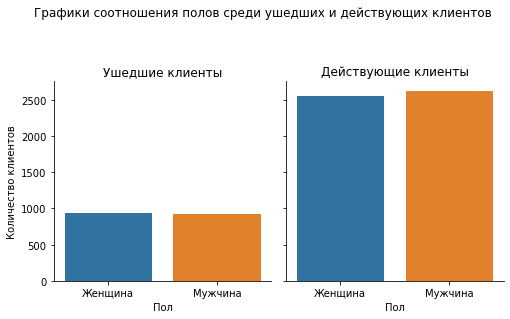

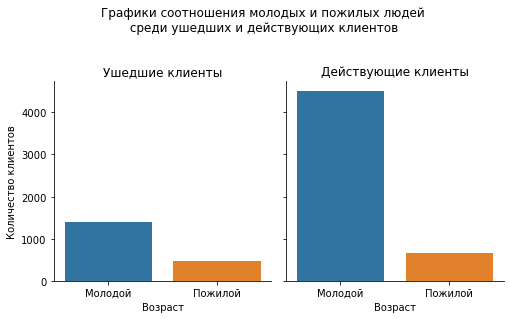

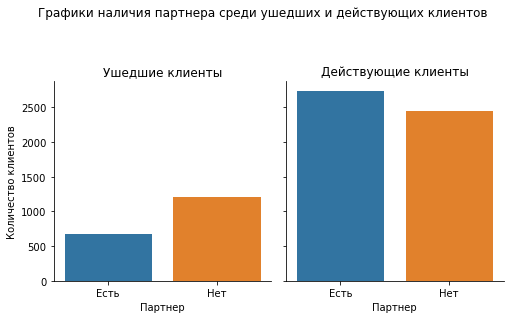

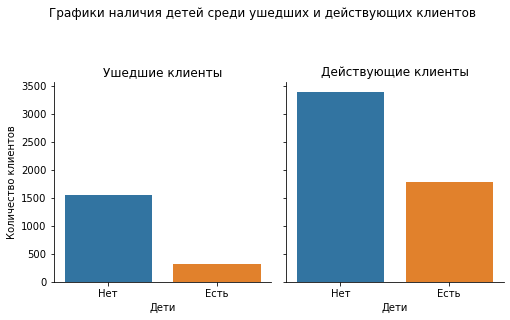

In [24]:
g = sns.catplot(x='gender', data=data, kind='count', col='Status', height=3.5)
axes = g.axes.flatten()
axes[0].set_title("Ушедшие клиенты")
axes[1].set_title("Действующие клиенты")
(g.set_axis_labels('Пол', 'Количество клиентов')
  .set_xticklabels(["Женщина", "Мужчина"])
  .fig.suptitle('Графики соотношения полов среди ушедших и действующих клиентов', y=1.2))

g = sns.catplot(x='SeniorCitizen', data=data, kind='count', col='Status', height=3.5)
axes = g.axes.flatten()
axes[0].set_title("Ушедшие клиенты")
axes[1].set_title("Действующие клиенты")
(g.set_axis_labels('Возраст', 'Количество клиентов')
  .set_xticklabels(["Молодой", "Пожилой"])
  .fig.suptitle('Графики соотношения молодых и пожилых людей\n среди ушедших и действующих клиентов', y=1.2))

g = sns.catplot(x='Partner', data=data, kind='count', col='Status', height=3.5)
axes = g.axes.flatten()
axes[0].set_title("Ушедшие клиенты")
axes[1].set_title("Действующие клиенты")
(g.set_axis_labels('Партнер', 'Количество клиентов')
  .set_xticklabels(["Есть", "Нет"])
  .fig.suptitle('Графики наличия партнера среди ушедших и действующих клиентов', y=1.2))

g = sns.catplot(x='Dependents', data=data, kind='count', col='Status', height=3.5)
axes = g.axes.flatten()
axes[0].set_title("Ушедшие клиенты")
axes[1].set_title("Действующие клиенты")
(g.set_axis_labels('Дети', 'Количество клиентов')
  .set_xticklabels(["Нет", "Есть"])
  .fig.suptitle('Графики наличия детей среди ушедших и действующих клиентов', y=1.2))

plt.show()

- По графикам можно сделать следующие выводы:
    1. Мужчины и женщины в одинаковой степени представлены среди действующих и неактивных клиентов
    2. Количество молодых людей по отношению к пожилым выше среди действующих клиентов, но в целом в обеих группах молодых людей значительно больше
    3. Среди ушедших клиентов больше людей без партнера
    4. Количество людей без детей по отношению к клиентам с детьми среди ушедших выше, чем среди действующих

- #### Рассмотрим предоставляемы услуги среди неактивных и действующих клиентов

- Будем считать, что если данные об услуге не указаны, значит она не предоставляется. Таким образом заполним пропуски

In [25]:
data = data.fillna('No')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

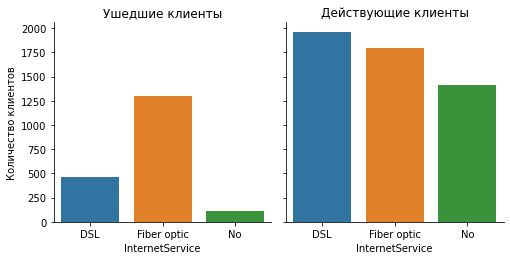

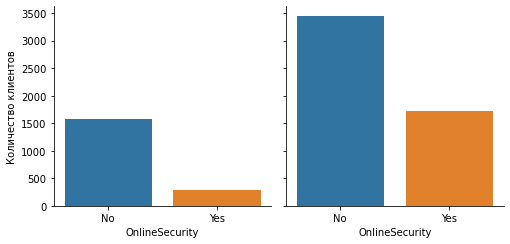

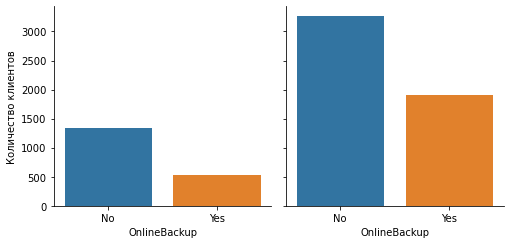

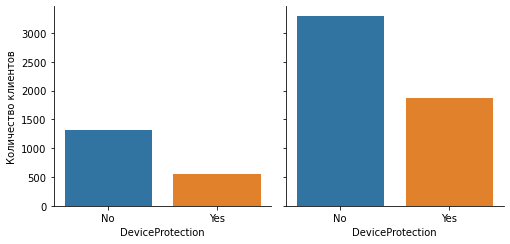

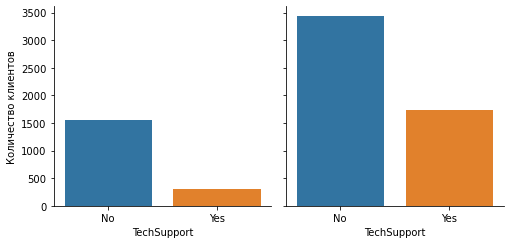

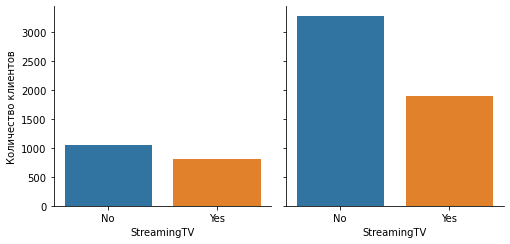

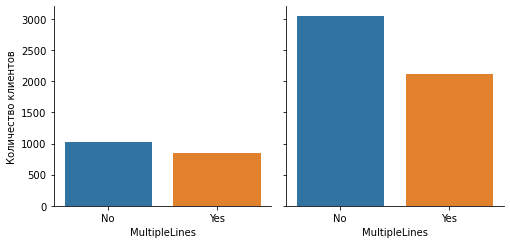

In [26]:
service_columns = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'MultipleLines']

for i in range(len(service_columns)):
    g = sns.catplot(x=service_columns[i], data=data.sort_values(by=service_columns[i]), kind='count', col='Status', height=3.5)
    axes = g.axes.flatten()
    if i==0:
        axes[0].set_title("Ушедшие клиенты")
        axes[1].set_title("Действующие клиенты")
    else:
        axes[0].set_title("")
        axes[1].set_title("")        
    (g.set_axis_labels(service_columns[i], 'Количество клиентов'))

plt.show()


- Из графиков можно сделать следующие выводы:


    1. За исключением интернета, соотношение предоставляемых и отключенных услуг среди ушедших и действующих клиентов схожее с небольшими девиациями например по техподдержке, онлайн-безопасности и стримингу
    
    2. Среди ушедших клиентов почти все пользовались подключением к интернету, преимущественно по оптоволокну, тогда как примерно треть дейстующих клиентов интернет подключение не использует, а остальная часть в равной степени выбирает оптоволоконное соединение и цифровую абонентскую линию

# Подготовка признаков <a class="anchor" id="6.2-bullet"></a>

- #### Изучив различные параметры и их соотношения, необходимо понять насколько достоверно для целей обучения модели мы можем предполагать, что активные новые клиенты, появившиеся к концу 2019 началу 2020 года, не являются "потенциально ушедшими" в коротктой перспективе. Т.е. надо определить, характеризуются ли новые клиенты как активные или склонные к тому, чтобы уйти. 

- Мы определили, что в большинстве случаев, если клиент собирается уйти, то скорее всего он сделает это в первые 200 дней пользования. 


- Среди новых активных клиентов попробуем выделить тех, кто потенциально уйдет через короткое время по следующим характерным криетриям:
    1. Тип договора: на месяц 
    2. Тип оплаты: электронный чек
    3. Подключение к интернету через оптоволокно

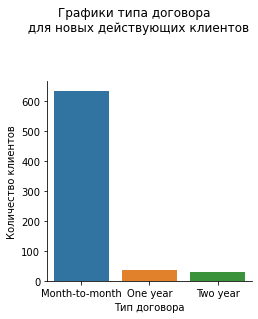

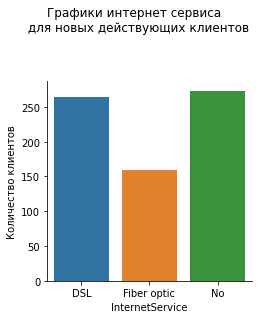

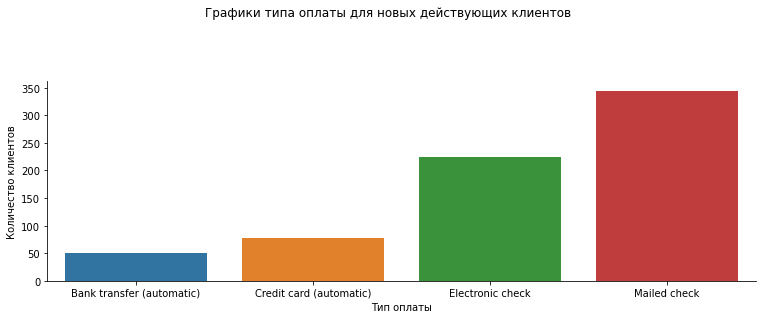

In [27]:
g = sns.catplot(x='Type', data=data.query('Status==1 and ContractDuration<200'), kind='count', col='Status', height=3.5)
axes = g.axes.flatten()
axes[0].set_title("")
(g.set_axis_labels('Тип договора', 'Количество клиентов')
  .fig.suptitle('Графики типа договора \n для новых действующих клиентов', y=1.2))

g = sns.catplot(x='InternetService', data=data.query('Status==1 and ContractDuration<200').sort_values(by='InternetService'), kind='count', col='Status', height=3.5)
axes = g.axes.flatten()
axes[0].set_title("")
(g.set_axis_labels('InternetService', 'Количество клиентов')
  .fig.suptitle('Графики интернет сервиса \n для новых действующих клиентов', y=1.2))

g = sns.catplot(x='PaymentMethod', data=data.query('Status==1 and ContractDuration<200').sort_values(by='PaymentMethod'), kind='count', col='Status', height=3.5, aspect=3/1)
axes = g.axes.flatten()
axes[0].set_title("")
(g.set_axis_labels('Тип оплаты', 'Количество клиентов')
  .fig.suptitle('Графики типа оплаты для новых действующих клиентов', y=1.2))

plt.show()

- Из новых клиентов значительную часть составляют те, кто выбрал помесячный договор. 


- Новых клиентов с продолжительным договором (1-2 года) точно возьмем для обучения. Чтобы не обрасывать слишком много остальных новых клиентов, попробуем среди них сделать выбор на основе интернет сервиса и типа оплаты

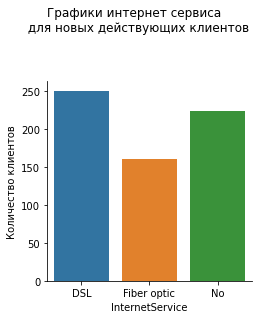

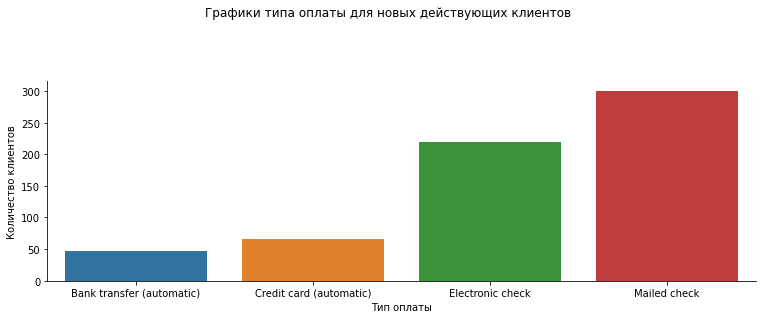

In [28]:
condition = 'Status==1 and ContractDuration<200 and Type=="Month-to-month"'

g = sns.catplot(x='InternetService', data=data.query(condition).sort_values(by='InternetService'), kind='count', col='Status', height=3.5)
axes = g.axes.flatten()
axes[0].set_title("")
(g.set_axis_labels('InternetService', 'Количество клиентов')
  .fig.suptitle('Графики интернет сервиса \n для новых действующих клиентов', y=1.2))

g = sns.catplot(x='PaymentMethod', data=data.query(condition).sort_values(by='PaymentMethod'), kind='count', col='Status', height=3.5, aspect=3/1)
axes = g.axes.flatten()
axes[0].set_title("")
(g.set_axis_labels('Тип оплаты', 'Количество клиентов')
  .fig.suptitle('Графики типа оплаты для новых действующих клиентов', y=1.2))

plt.show()

- Среди оставшихся новых клиентов выберем тех кто не подключал интернет

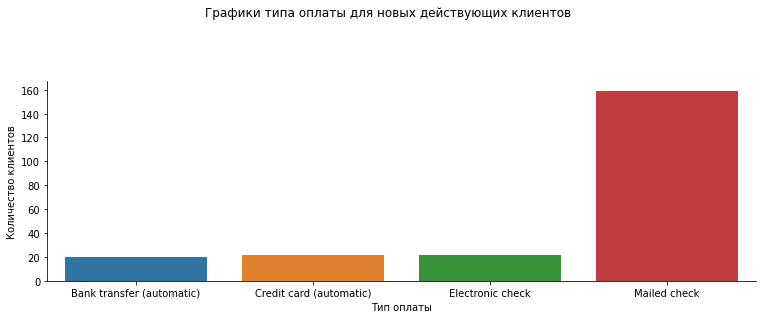

In [29]:
condition = 'Status==1 and ContractDuration<200 and Type=="Month-to-month" and InternetService=="No"'

g = sns.catplot(x='PaymentMethod', data=data.query(condition).sort_values(by='PaymentMethod'), kind='count', col='Status', height=3.5, aspect=3/1)
axes = g.axes.flatten()
axes[0].set_title("")
(g.set_axis_labels('Тип оплаты', 'Количество клиентов')
  .fig.suptitle('Графики типа оплаты для новых действующих клиентов', y=1.2))

plt.show()

- Дополнительно проведем фильтрацию новых клиентов, которые не использовали электорнный чек для оплаты

In [30]:
condition_new_active_clients = 'Status==1 and ContractDuration<200'
condition_filt_new_active_clients = 'Status==1 and ContractDuration<200 and ((Type!="Month-to-month") or (Type=="Month-to-month"and InternetService=="No" and PaymentMethod!="Electronic check"))'

print('Исходное количество новых активных клиентов: ', len(data.query(condition_new_active_clients)))
print('Количество вероятных новых активных клиентов: ', len(data.query(condition_filt_new_active_clients)))


Исходное количество новых активных клиентов:  697
Количество вероятных новых активных клиентов:  265


- Таким образом, мы оставили новых клиентов с наиболее вероятными характеристиками пользователей, которые не уйдут в ближайшее время. Тем самым мы не внесем потенциальную ошибку при обучение модели 

In [31]:
data_precon = data.drop(data.query(condition_filt_new_active_clients).index)

data_precon.info()
display(data_precon.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6778 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        6778 non-null   object        
 1   BeginDate         6778 non-null   datetime64[ns]
 2   EndDate           6778 non-null   object        
 3   Type              6778 non-null   object        
 4   PaperlessBilling  6778 non-null   object        
 5   PaymentMethod     6778 non-null   object        
 6   MonthlyCharges    6778 non-null   float64       
 7   TotalCharges      6778 non-null   float64       
 8   gender            6778 non-null   object        
 9   SeniorCitizen     6778 non-null   int64         
 10  Partner           6778 non-null   object        
 11  Dependents        6778 non-null   object        
 12  InternetService   6778 non-null   object        
 13  OnlineSecurity    6778 non-null   object        
 14  OnlineBackup      6778 n

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Status,ContractDuration
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,DSL,No,Yes,No,No,No,No,No,1,31.0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,1,1036.0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,61.0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,No,1,1371.0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,61.0


- #### Удалим лишние столбцы:


    - customerID - неиформативный
    - BeginDate/EndDate заменяют ContractDuration и целевым Status
    - TotalCharges - выводится из ContractDuration и MonthlyCharges

In [32]:
data_precon.drop(columns=['customerID', 'BeginDate', 'EndDate', 'TotalCharges'], inplace=True)
data_precon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6778 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              6778 non-null   object 
 1   PaperlessBilling  6778 non-null   object 
 2   PaymentMethod     6778 non-null   object 
 3   MonthlyCharges    6778 non-null   float64
 4   gender            6778 non-null   object 
 5   SeniorCitizen     6778 non-null   int64  
 6   Partner           6778 non-null   object 
 7   Dependents        6778 non-null   object 
 8   InternetService   6778 non-null   object 
 9   OnlineSecurity    6778 non-null   object 
 10  OnlineBackup      6778 non-null   object 
 11  DeviceProtection  6778 non-null   object 
 12  TechSupport       6778 non-null   object 
 13  StreamingTV       6778 non-null   object 
 14  StreamingMovies   6778 non-null   object 
 15  MultipleLines     6778 non-null   object 
 16  Status            6778 non-null   int64  


- #### Проведем кодировку категориальных признаков

- Для удобства заменим 'да/нет' в различных признаках на 1 и 0 соответственно

In [33]:
data_precon = data_precon.replace('No', 0)
data_precon = data_precon.replace('Yes', 1)
display(data_precon.head(5))

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Status,ContractDuration
0,Month-to-month,1,Electronic check,29.85,Female,0,1,0,DSL,0,1,0,0,0,0,0,1,31.0
1,One year,0,Mailed check,56.95,Male,0,0,0,DSL,1,0,1,0,0,0,0,1,1036.0
2,Month-to-month,1,Mailed check,53.85,Male,0,0,0,DSL,1,1,0,0,0,0,0,0,61.0
3,One year,0,Bank transfer (automatic),42.30,Male,0,0,0,DSL,1,0,1,1,0,0,0,1,1371.0
4,Month-to-month,1,Electronic check,70.70,Female,0,0,0,Fiber optic,0,0,0,0,0,0,0,0,61.0


- Для остальных категориальных признаков используем автоматическое кодирование OHE

In [34]:
data_precon = pd.get_dummies(data_precon, drop_first=True)

data_precon.info()

display(data_precon.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6778 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   PaperlessBilling                       6778 non-null   int64  
 1   MonthlyCharges                         6778 non-null   float64
 2   SeniorCitizen                          6778 non-null   int64  
 3   Partner                                6778 non-null   int64  
 4   Dependents                             6778 non-null   int64  
 5   OnlineSecurity                         6778 non-null   int64  
 6   OnlineBackup                           6778 non-null   int64  
 7   DeviceProtection                       6778 non-null   int64  
 8   TechSupport                            6778 non-null   int64  
 9   StreamingTV                            6778 non-null   int64  
 10  StreamingMovies                        6778 non-null   int64  
 11  Mult

,PaperlessBilling,MonthlyCharges,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,Status,ContractDuration,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,InternetService_DSL,InternetService_Fiber optic
0,1,29.85,0,1,0,0,1,0,0,0,...,1,31.0,0,0,0,1,0,0,1,0
1,0,56.95,0,0,0,1,0,1,0,0,...,1,1036.0,1,0,0,0,1,1,1,0
2,1,53.85,0,0,0,1,1,0,0,0,...,0,61.0,0,0,0,0,1,1,1,0
3,0,42.30,0,0,0,1,0,1,1,0,...,1,1371.0,1,0,0,0,0,1,1,0
4,1,70.70,0,0,0,0,0,0,0,0,...,0,61.0,0,0,0,1,0,0,0,1


- #### Разделим данные на тестовую и обучающую выборку в отношении 1:4


----- Обучающая выборка: -----

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5422 entries, 3851 to 4755
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   PaperlessBilling                       5422 non-null   int64  
 1   MonthlyCharges                         5422 non-null   float64
 2   SeniorCitizen                          5422 non-null   int64  
 3   Partner                                5422 non-null   int64  
 4   Dependents                             5422 non-null   int64  
 5   OnlineSecurity                         5422 non-null   int64  
 6   OnlineBackup                           5422 non-null   int64  
 7   DeviceProtection                       5422 non-null   int64  
 8   TechSupport                            5422 non-null   int64  
 9   StreamingTV                            5422 non-null   int64  
 10  StreamingMovies                     

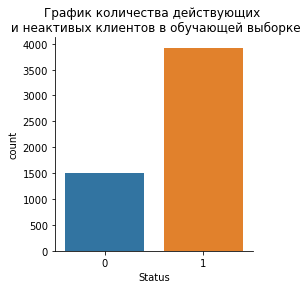

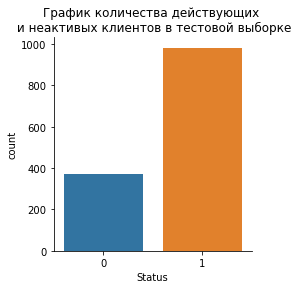

In [35]:
train, test = train_test_split(data_precon, test_size=0.2, random_state=RANDOM_STATE)

print()
print('----- Обучающая выборка: -----')
print()
train.info()

print()
print('----- Тестовая выборка: -----')
print()
test.info()

sns.catplot(x='Status', data=train, kind='count', height=3.5)
plt.title('График количества действующих \n и неактивых клиентов в обучающей выборке')
plt.show()

sns.catplot(x='Status', data=test, kind='count', height=3.5)
plt.title('График количества действующих \n и неактивых клиентов в тестовой выборке')
plt.show()

- #### Мы имеем дело с несбалансированными данными - число ушедших клиентов более чем в 2 раза меньше количества действующих. Эту информацию необходимо учитывать при построении модели. 

- #### Если дисбаланс классов снизит качество предсказания, мы можем применить следующие подходы на этапе построения модели:


    - Учет дисбаланса в алгоритме модели
    - Балансировка добавлением значений наименнее представленного класса - Upsampling
    - Балансировка удалением значений наиболее представленного класса - Downsampling
    - Использование стратифицированной кросс-валидации

- #### Проведем масштабирование количественных признаков

In [36]:
warnings.filterwarnings('ignore')

numerical_columns = ['MonthlyCharges', 'ContractDuration']

print('Количественные признаки до масштабирования:')
display(train[numerical_columns].head(5))

scaler = MinMaxScaler(feature_range=(0, 1))

scaler.fit(train[numerical_columns]) 

train[numerical_columns] = scaler.transform(train[numerical_columns])
test[numerical_columns] = scaler.transform(test[numerical_columns])

print('\nКоличественные признаки после масштабирования:')
display(train[numerical_columns].head(5))

Количественные признаки до масштабирования:


,MonthlyCharges,ContractDuration
3851,19.25,1401.0
4110,67.95,2132.0
6016,108.45,2068.0
1671,103.15,2010.0
5567,103.00,1492.0



Количественные признаки после масштабирования:


,MonthlyCharges,ContractDuration
3851,0.009960,0.634429
4110,0.495020,0.972698
6016,0.898406,0.943082
1671,0.845618,0.916242
5567,0.844124,0.676539


- #### Разделим признаки на обучающие и целевой

In [37]:
X_train = train.drop(['Status'], axis=1)
y_train = train['Status']

X_test = test.drop(['Status'], axis=1)
y_test = test['Status']

# Построение моделей <a class="anchor" id="7-bullet"></a>

- #### При обучении с учетом дисбаланса классов воспользуемся кросс-валидацией

In [38]:
cv = StratifiedShuffleSplit(n_splits=5, random_state=RANDOM_STATE)

### 1. Модель случайный лес с весами

- #### Создадим модель

In [39]:
random_forest_model = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

- #### Создадим сетку гипер-параметров

In [40]:
param_grid_random_forest = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(1, 200, 10),
    'max_features' : ['auto', 'sqrt', 'log2', None],
    'min_samples_leaf' :  range(1, 20),
    'n_estimators' :  range(1, 300, 10)
}

- #### Найдем наилучшие гипер-параметры на заданной сетке по метрике 'ROC-AUC' с помощью метода рандомизированного поиска

In [41]:
%%time

grid_cv_random_forest = RandomizedSearchCV(random_forest_model, param_grid_random_forest, cv=cv, n_iter=100, scoring='roc_auc').fit(X_train, y_train)

Wall time: 6min


- #### Оценим результат


- Построим график важности признаков для модели "Случайный лес"


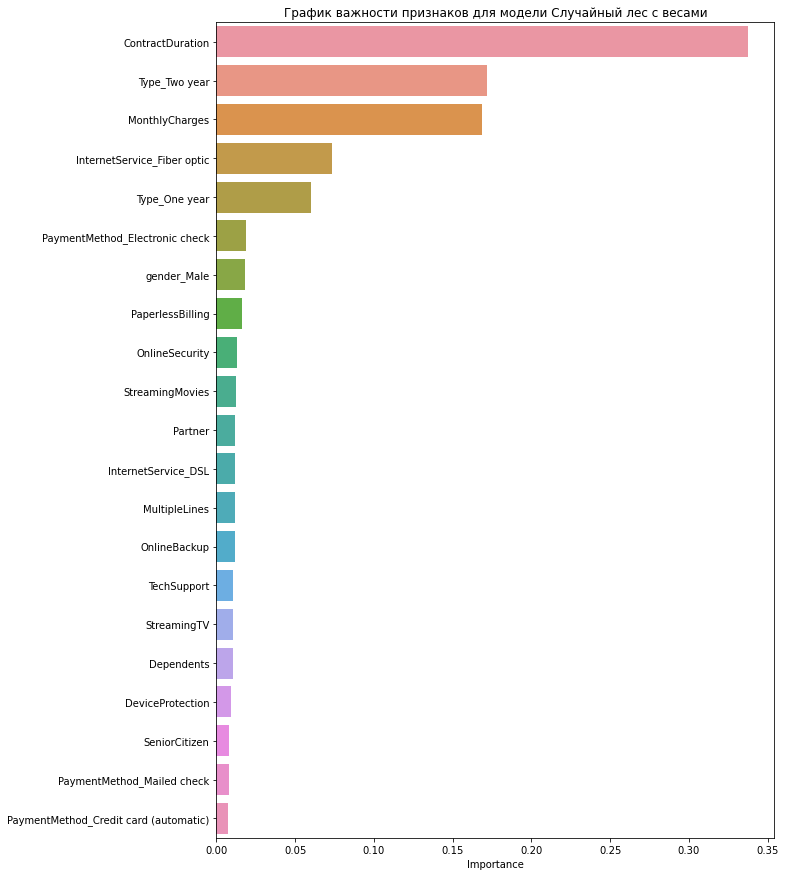

In [65]:
importance = grid_cv_random_forest.best_estimator_.feature_importances_
df_importance = pd.DataFrame(importance, columns=['Importance'],index=X_train.columns).sort_values(by='Importance', ascending=False)
fig, ax = plt.subplots(figsize=(10,15))
ax = sns.barplot(df_importance['Importance'], df_importance.index)

plt.title('График важности признаков для модели Случайный лес с весами')
plt.show()


- Из графика важности признаков для модели "Случайный лес" можно сделать вывод, что как и следовало из анализа данных наиболее значимыми оказались признаки: 

    1. Длительность контракта
    2. Тип контракта (1-2 года)
    3. Ежемесячный платеж
    4. Наличие оптоволоконного соединения
    
    
- Кривые ROC и площадь под ней - основная метрика AUC-ROC повзволяет оценить насколько хорошо наша модель предсказала правильные ответы, в том числе по сравнению со случайной. Также мы можем понять соотношение положительных и ложно положительных ответов модели

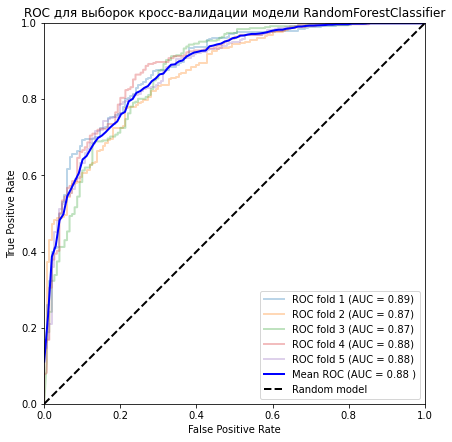

,Модель,Метрика AUC-ROC
0,Случайный лес с весами,0.87


In [42]:
cv_auc_roc_curve(X_train, y_train, cv, grid_cv_random_forest)

auc_roc_random_forest = round(grid_cv_random_forest.best_score_, 2)

columns = ['Модель', 'Метрика AUC-ROC']
random_forest_results = { 'Модель' : 'Случайный лес с весами',
                          'Метрика AUC-ROC' : [auc_roc_random_forest],
                        }
display(pd.DataFrame(random_forest_results, columns=columns))

- #### Модель случайный лес с весами показала удовлетворительный результат на валидационной выборке (0.85 ≤ AUC-ROC < 0.87)

- #### Попробуем рассмотреть другой алгоритм обучения

### 2. Модель градиентного бустинга

- #### Создадим модель

In [43]:
gb_model = GradientBoostingClassifier(random_state=RANDOM_STATE) 

- #### Создадим сетку гипер-параметров

In [44]:
param_grid_gb = {
    'loss' : ['deviance', 'exponential'],
    'learning_rate' : [0.1],
    'n_estimators' : range(1, 100, 10),
    'max_depth' : range(1, 200, 10)
}

- #### Найдем наилучшие гипер-параметры на заданной сетке по метрике 'ROC-AUC' с помощью метода рандомизированного поиска

In [45]:
%%time

grid_cv_gb = RandomizedSearchCV(gb_model, param_grid_gb, cv=cv, n_iter=100, scoring='roc_auc').fit(X_train, y_train)

Wall time: 15min 8s


- #### Оценим результат

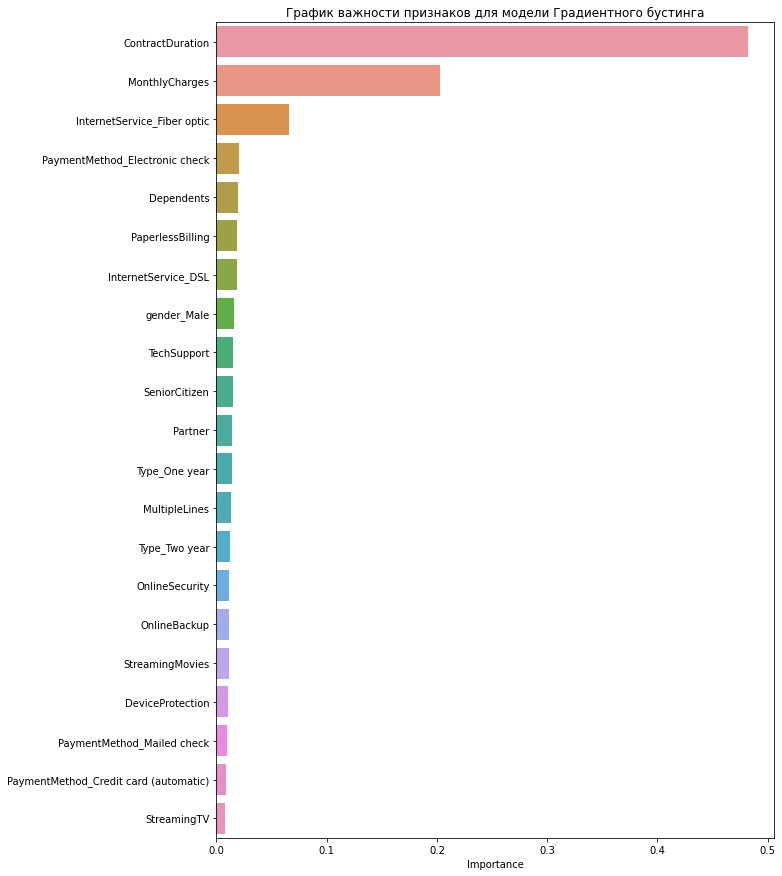

In [67]:
importance = grid_cv_gb.best_estimator_.feature_importances_
df_importance = pd.DataFrame(importance, columns=['Importance'],index=X_train.columns).sort_values(by='Importance', ascending=False)
fig, ax = plt.subplots(figsize=(10,15))
ax = sns.barplot(df_importance['Importance'], df_importance.index)

plt.title('График важности признаков для модели Градиентного бустинга')
plt.show()


- Из графика важности признаков для модели "Градиентный бустинг" можно сделать вывод, что наибольшое влияние оказывают признаки: 

    1. Длительность контракта
    2. Ежемесячный платеж
    3. Наличие оптоволоконного соединения

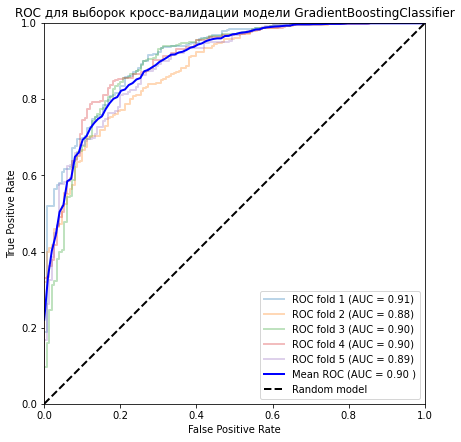

,Модель,Метрика AUC-ROC
0,Градиентный бустинг,0.9


In [46]:
cv_auc_roc_curve(X_train, y_train, cv, grid_cv_gb)

auc_roc_gradient_boosting = round(grid_cv_gb.best_score_, 2)

columns = ['Модель', 'Метрика AUC-ROC']
gradient_boosting_results = { 'Модель' : 'Градиентный бустинг',
                          'Метрика AUC-ROC' : [auc_roc_gradient_boosting],
                        }
display(pd.DataFrame(gradient_boosting_results, columns=columns))

- #### Модель градиентного бустинга также показала хороший результат на валидационной выборке 

# Тестирование моделей <a class="anchor" id="8-bullet"></a>

- #### Проведем тестирование моделей с подобранными при построении параметрами

In [47]:
random_forest_model = RandomForestClassifier(random_state=RANDOM_STATE, 
                                             class_weight='balanced', 
                                             **grid_cv_random_forest.best_params_).fit(X_train, y_train)

roc_auc_random_forest = roc_auc_score(y_test, random_forest_model.predict_proba(X_test)[:, 1])

accuracy_random_forest = accuracy_score(y_test, random_forest_model.predict(X_test))

In [48]:
gradient_boosting_model = GradientBoostingClassifier(**grid_cv_gb.best_params_).fit(X_train, y_train)

roc_auc_gradient_boosting = roc_auc_score(y_test, gradient_boosting_model.predict_proba(X_test)[:, 1])

accuracy_gradient_boosting = accuracy_score(y_test, gradient_boosting_model.predict(X_test))

- #### Сведем результаты тестирования в общую таблицу


- Оценивать будем главным образом метрику AUC-ROC и вспомогательную Accuracy-точность


- Скорость предсказания и построения модели в данном случае будут не показательными, т.к. наборы очень маленькие

In [49]:
columns = ['Метрика AUC-ROC', 'Метрика Accuracy']

test_results = { 'Метрика AUC-ROC' : [roc_auc_random_forest, roc_auc_gradient_boosting],
                          'Метрика Accuracy': [accuracy_random_forest, accuracy_gradient_boosting]
                        }

index = ['Модель случайный лес с весами', 'Модель градиентного бустинга']

display(round(pd.DataFrame(test_results, columns=columns, index=index), 2))

,Метрика AUC-ROC,Метрика Accuracy
Модель случайный лес с весами,0.89,0.83
Модель градиентного бустинга,0.91,0.85


- #### Метрики моделей на тестовых выборках достаточно высокие, однако модель градиентного бустинга показала более хорошие результаты (AUC-ROC > 0.88)

# Общий вывод <a class="anchor" id="9-bullet"></a>

1. Были проанализированный все предоставленные данные о пользователях


2. На основании анализа можно выделить следующие характерные признаки клиентов, которые собираются уйти: 
    а) В основном клиенты принимают решение об уходе в первые 6-7 месяцев пользования
    б) Тип договора в основном ежемесячный
    в) Большинство выбирает подключение к интернету по оптоволокну


3. Персональная информация о клиентах является наиболее малоинформативной для целей задачи


4. Данные были предобработаны. Часть данных о новых клиентах была отброшена перед обучением моделей, т.к. малая длительность контракта не позволяет с уверенностью разделить пользователей на классы


6. С учетом дисбаланса данных были опробованы два типа алгортима обучения - "Случайный лес с весами" и "Градиентный бустинг" 


7. Проведено тестирование моделей с оптимальными параметрами, по результатам которого выбрана модель "Градиентоного бустинга", показавшая высокие значения точности  

- ##### На основании финальных метрик можно утверждать, что модель "Градиентого бустинга" позволит уверенно определять клиентов, которые собираются уйти, для предложения им специальных условий, а низкая доля ложно положительных предсказаний позволит сэкономить на нецелесообразном преоставлении скидок постоянным клиентам 